# Laplace problem

We first consider a simple Laplace problem with Dirichlet boundary conditions
\begin{align*}
-\Delta u &= f, && \text{in } \Omega, \\
u &= g, && \text{on } \partial\Omega,
\end{align*}
with $\Omega=[-\frac{1}{2},1]^2$ and choosing the forcing and the boundary conditions
so that the exact solution is equal to
\begin{align*}
u(x,y) &= xy\cos(\pi xy)
\end{align*}

First some setup code:

In [1]:
try:
    import dune.vem
except:
    import sys
    sys.exit(0)
import matplotlib
matplotlib.rc( 'image', cmap='jet' )
from matplotlib import pyplot
import math
from dune import create
from dune.grid import cartesianDomain, gridFunction
from dune.fem.plotting import plotPointData as plot
from dune.fem.function import integrate
from dune.fem import parameter
from dune.vem import voronoiCells

from ufl import *
import dune.ufl

order = 3

dune.fem.parameter.append({"fem.verboserank": 0})

we can compare different method, e.g., a lagrange space (on the # subtriangulation),
a bounding box dg space and a conforming/non conforming VEM space

In [2]:
uflSpace = dune.ufl.Space(2, dimRange=1)
x = SpatialCoordinate(uflSpace)
exact = as_vector( [x[0]*x[1] * cos(pi*x[0]*x[1])] )
massCoeff = 1+sin(dot(x,x))
diffCoeff = 1-0.9*cos(dot(x,x))

methods = [ ### "[legend,space,scheme,spaceKwargs,schemeKwargs]"
            ["lagrange","lagrange","galerkin",{},{}],
            ["vem-conforming","vem","vem",
                {"testSpaces":[0,order-2,order-2]},  # conforming
                {"gradStabilization":diffCoeff, "massStabilization":massCoeff}],
            ["vem-nonconforming","vem","vem",
                 {"testSpaces":[-1,order-1,order-2]},  # non-conforming
                 {"gradStabilization":diffCoeff, "massStabilization":massCoeff}],
            ["bb-dg","bbdg","bbdg", {}, {"penalty":diffCoeff}],
            ["dg","dgonb","dg", {}, {"penalty":diffCoeff}],
   ]
parameters = {"newton.linear.tolerance": 1e-12,
              "newton.linear.preconditioning.method": "jacobi",
              "penalty": 10*order*order,  # for the bbdg scheme
              "newton.linear.verbose": False,
              "newton.verbose": False
              }

Now we define the model starting with the exact solution:

In [3]:
u = TrialFunction(uflSpace)
v = TestFunction(uflSpace)
a = (diffCoeff*inner(grad(u),grad(v)) + massCoeff*dot(u,v) ) * dx

# finally the right hand side and the boundary conditions
b = (-div(diffCoeff*grad(exact[0])) + massCoeff*exact[0] ) * v[0] * dx
dbc = [dune.ufl.DirichletBC(uflSpace, exact, i+1) for i in range(4)]

Now we define a grid build up of voronoi cells around $50$ random points

In [4]:
constructor = cartesianDomain([-0.5,-0.5],[1,1],[10,10])
polyGrid = create.grid("polygrid", voronoiCells(constructor,50,"voronoiseeds",True,lloyd=100) )

loading seeds for voronoi grid


In general we can construct a `polygrid` by providing a dictionary with
the `vertices` and the `polygons`. The `voronoiCells` function creates
such a dictonary using random seeds to generate voronoi cells which are
cut off using the provided `cartesianDomain`. The seeds can be
provided as list of points as second argument:
```
voronoiCells(constructor, towers, fileName=None, load=False):
```
If a `fileName` is provided the seeds will be written to disc and loaded
from that file is `load=True`. As an example the output of
`voronoiCells(constructor,5)` is
```
{'polygons': [ [4, 5, 2, 3], [ 8, 10,  9,  7], [7, 9, 1, 3, 4],
               [11, 10,  8,  0], [8, 0, 6, 5, 4, 7] ],
 'vertices': [ [ 0.438, 1.  ],    [ 1. , -0.5 ],
               [-0.5, -0.5  ],    [ 0.923, -0.5 ],
               [ 0.248,  0.2214], [-0.5,  0.3027],
               [-0.5,  1. ],      [ 0.407,0.4896],
               [ 0.414,  0.525],  [ 1.,  0.57228],
               [ 1., 0.88293],    [ 1.,  1. ] ] }
```

Let's take a look at the grid with the 50 polygons triangulated

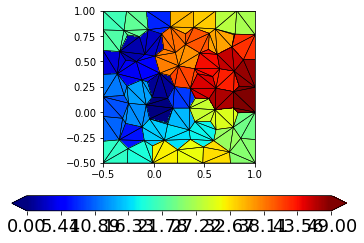

In [5]:
@gridFunction(polyGrid, name="cells")
def polygons(en,x):
    return polyGrid.hierarchicalGrid.agglomerate(en)
polygons.plot(colorbar="horizontal")

We now define a function to compute the solution and the $L^2,H^1$ error
given a grid and a space

In [6]:
def compute(grid, space, schemeName, schemeArgs):
    # solve the pde
    df = space.interpolate([0],name="solution")
    scheme = create.scheme(schemeName, [a==b, *dbc], space,
                   solver="cg", **schemeArgs,
                   parameters=parameters)
    info = scheme.solve(target=df)

    # compute the error
    edf = exact-df
    err = [inner(edf,edf),
           inner(grad(edf),grad(edf))]
    errors = [ math.sqrt(e) for e in integrate(grid, err, order=8) ]

    return df, errors, info

Finally we iterate over the requested methods and solve the problems

method:( lagrange galerkin ) Size:  832 L^2:  0.00014536274993658913 H^1:  0.006394242508359298 236


method:( vem-conforming vem ) Size:  554 L^2:  0.0004667890572698243 H^1:  0.01198275840423522 141


method:( vem-nonconforming vem ) Size:  603 L^2:  0.0004151887665658781 H^1:  0.01323093598822407 135


method:( bb-dg bbdg ) Size:  500 L^2:  0.000407931336466342 H^1:  0.014067433416042927 414


method:( dg dg ) Size:  1760 L^2:  0.00013327874401727638 H^1:  0.00627634352293945 2545


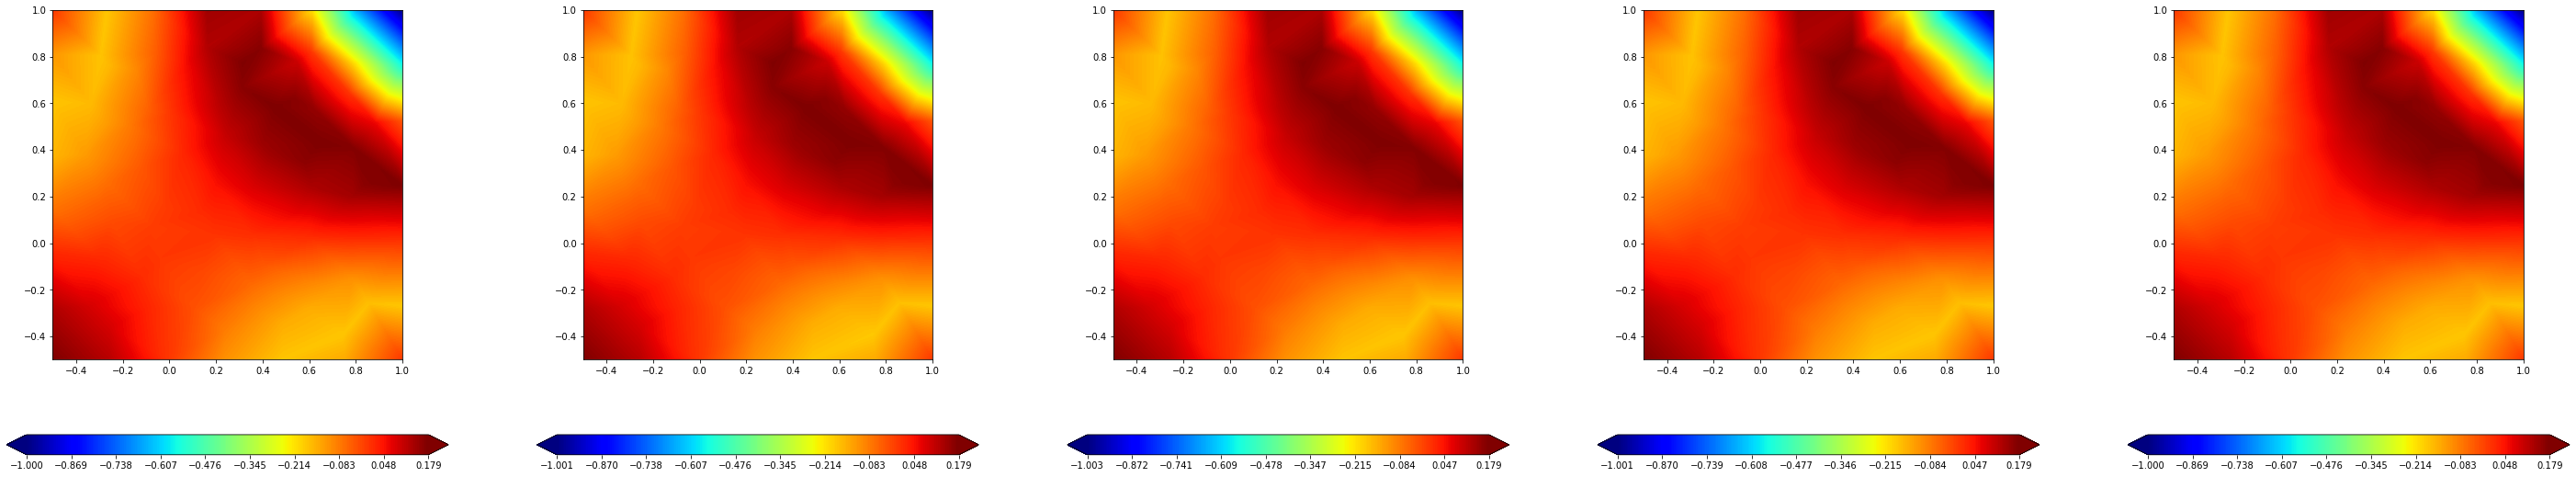

In [7]:
fig = pyplot.figure(figsize=(10*len(methods),10))
figPos = 100+10*len(methods)+1
for i,m in enumerate(methods):
    space = create.space(m[1], polyGrid, order=order, dimRange=1, storage="istl", **m[3])
    dfs,errors,info = compute(polyGrid, space, m[2], m[4])
    print("method:(",m[0],m[2],")",
          "Size: ",space.size, "L^2: ", errors[0], "H^1: ", errors[1],
          info["linear_iterations"], flush=True)
    dfs.plot(figure=(fig,figPos+i),gridLines=None, colorbar="horizontal")
pyplot.show()

# Nonlinear elliptic problem
We can easily set up a non linear problem

[0.009013780575622663, 0.15064980635864458]


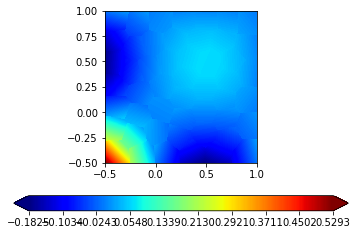

In [8]:
space = create.space("vem", polyGrid, order=1, dimRange=1, storage="istl",
                     conforming=True)
u = TrialFunction(space)
v = TestFunction(space)
x = SpatialCoordinate(space)
exact = as_vector ( [  (x[0] - x[0]*x[0] ) * (x[1] - x[1]*x[1] ) ] )
Dcoeff = lambda u: 1.0 + u[0]**2
a = (Dcoeff(u) * inner(grad(u), grad(v)) ) * dx
b = -div( Dcoeff(exact) * grad(exact[0]) ) * v[0] * dx
dbcs = [dune.ufl.DirichletBC(space, exact, i+1) for i in range(4)]
scheme = create.scheme("vem", [a==b, *dbcs], space,
        gradStabilization=Dcoeff(u),
        solver="cg", parameters=parameters)
solution = space.interpolate([0], name="solution")
info = scheme.solve(target=solution)
edf = exact-solution
errors = [ math.sqrt(e) for e in
           integrate(polyGrid, [inner(edf,edf),inner(grad(edf),grad(edf))], order=5) ]
print( errors )
solution.plot(gridLines=None, colorbar="horizontal")

# Linear Elasticity
As final example we solve a linear elasticity equation usign a
conforming VEM space:

First we setup the domain

loading seeds for voronoi grid


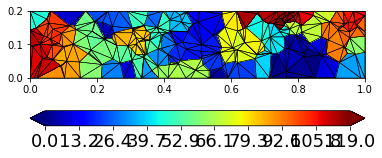

In [9]:
L, W = 1, 0.2

constructor = cartesianDomain([0,0],[L,W],[1,1])
polyGrid = create.grid("polygrid", voronoiCells(constructor,120,"voronoiseeds",True) )
@gridFunction(polyGrid, name="cells")
def polygons(en,x):
    return polyGrid.hierarchicalGrid.agglomerate(en)
polygons.plot(colorbar="horizontal")

space = create.space("vem", polyGrid, order=2, dimRange=2, storage="istl",
                     conforming=True)

In [10]:
# some model constants
mu = 1
rho = 1
delta = W/L
gamma = 0.4*delta**2
beta = 1.25
lambda_ = beta
g = gamma

# clamped boundary on the left
x = SpatialCoordinate(space)
dbc = dune.ufl.DirichletBC(space, as_vector([0,0]), x[0]<1e-10)

# Define strain and stress
def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
def sigma(u):
    return lambda_*nabla_div(u)*Identity(2) + 2*mu*epsilon(u)

# Define the variational problem
u = TrialFunction(space)
v = TestFunction(space)
f = dune.ufl.Constant((0, -rho*g))
a = inner(sigma(u), epsilon(v))*dx
b = dot(as_vector([0,-rho*g]),v)*dx

# Compute solution
displacement = space.interpolate([0,0], name="displacement")
scheme = create.scheme("vem", [a==b, dbc], space,
        gradStabilization = as_vector([lambda_+2*mu, lambda_+2*mu]),
        solver="cg", parameters=parameters)
info = scheme.solve(target=displacement)

Show the magnitude of the displacement field, stress and the deformed beam

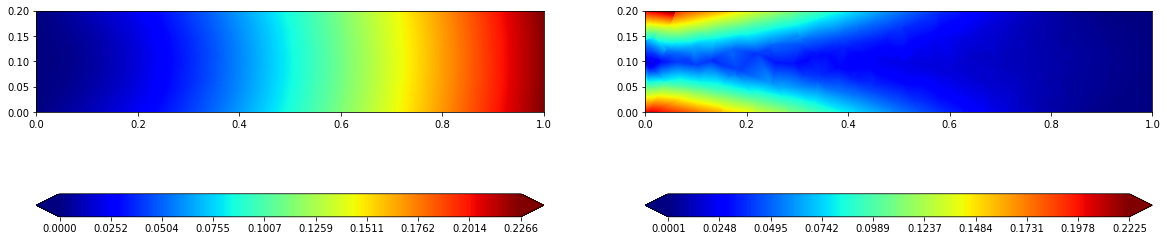

In [11]:
fig = pyplot.figure(figsize=(20,10))
displacement.plot(gridLines=None, figure=(fig, 121), colorbar="horizontal")
s = sigma(displacement) - (1./3)*tr(sigma(displacement))*Identity(2)
von_Mises = sqrt(3./2*inner(s, s))
plot(von_Mises, grid=polyGrid, gridLines=None, figure=(fig, 122), colorbar="horizontal")
pyplot.show()

Finally we plot the deformed beam

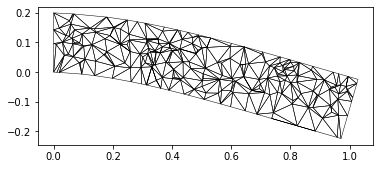

In [12]:
from dune.fem.view import geometryGridView
position = space.interpolate( x+displacement, name="position" )
beam = geometryGridView( position )
beam.plot()